# **Ejemplo de GPU Escala de Grises**

Este ejercicio se ha optado para aplicar 2 multidimensiones en GPU. El ejemplo modifica el color de una imagen parametrizada a escala de grises. El cálculo de la escala se realiza convirtiendo los 3 canales RGB, que representan a los colores R (*rojo*)-G(*verde*)-B(*azul*), de cada pixel siguiendo la ecuación:

<center>$ Pixel=R*0.30+G*0.59+B*0.11$</center>

EL objetivo es enseñar el funcionamiento del Lenguaje Python, CUDA y el manejo de imágenes a bajo nivel. El ejemplo es ilustrativo, ya que internamente el módulo Pillow posee varios filtros integrados.



---
# 2 Armado del ambiente
Toma la dirección web de una imagen con acceso público en internet, la deja disponible al contexto de ejecución del cuaderno Colab.

In [ ]:
#@title # 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://raw.githubusercontent.com/soa-pc-unlam/ProgramacionConcurrente/main/Enunciados%20TPs/TP-GPU/MesiCopa.jpg" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución.
!wget {url_imagen} -O imagen.jpg




--2023-11-01 20:39:00--  https://raw.githubusercontent.com/soa-pc-unlam/ProgramacionConcurrente/main/Enunciados%20TPs/TP-GPU/MesiCopa.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209591 (205K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 204.68K  --.-KB/s    in 0.02s   

2023-11-01 20:39:01 (8.42 MB/s) - ‘imagen.jpg’ saved [209591/209591]



---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [ ]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.6 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp310-cp310-linux_x86_64.whl size=661265 sha256=0d7a37e21881066a540b5083f2c5513f56da794b8d3643cb6afb14384cba3e97
  Stored in directory: /root/.cache/pip/wheels/1d/7b/06/82a395a243fce00035dea9914d92bbef0013401497d849f8bc
Successfully built pycuda


---
# 3 Desarrollo
Ejecución del algoritmo escala de grises en GPU.

Imagen del filtro:  imagen.jpg  - tipo  RGB - [ 1024 ,  768 ]
Imagen del filtro:  imagen.jpg  - tipo  RGB - [ 1024 ,  768 ]
Grilla : [ 171 , 128 ], Bloques: [ 6 , 6  ] 


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


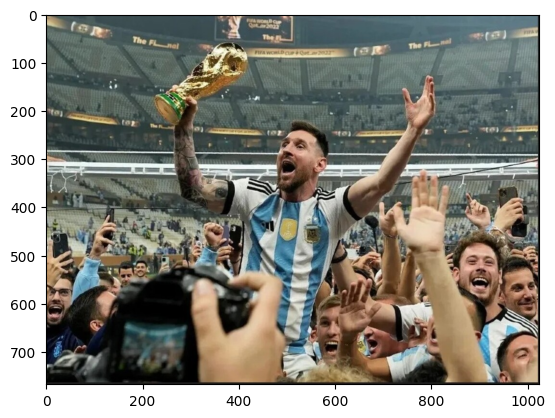

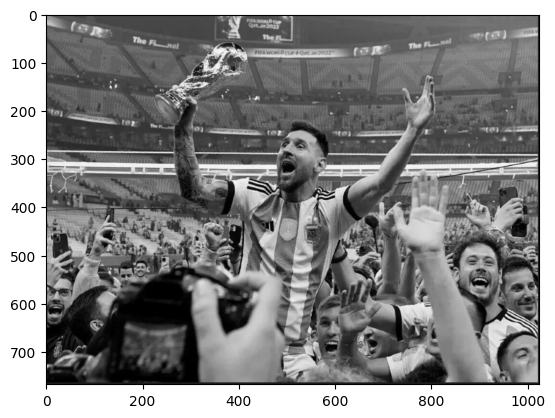

In [ ]:
#Comentar esta linea para mostrar las imagenes
#%%writefile filter_image.py

#Comentar esta linea para medir los tiempos
%matplotlib inline

import matplotlib.pyplot as plt
import numpy
from PIL import Image
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# -----------------------------------------------------------------------------
img_nombre = 'imagen.jpg'
image = Image.open( img_nombre )

# summarize some details about the image
img_ancho, img_alto  = image.size

# -----------------------------------------------------------------------------
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# -----------------------------------------------------------------------------

module = SourceModule("""
#define PIXEL_ROJO( x,y) (x+(y*ancho))*3
#define PIXEL_VERDE(x,y) PIXEL_ROJO(x,y) + 1
#define PIXEL_AZUL( x,y) PIXEL_ROJO(x,y) + 2

__global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float fGris = 0.0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el color gris para el pixel a partir de los componentes.
    fGris = (float)img_O[ PIXEL_ROJO(  idx, idy ) ]*0.29;  // Componente Rojo del pixel.
    fGris +=(float)img_O[ PIXEL_VERDE( idx, idy ) ]*0.59;  // Componente Verde del pixel.
    fGris +=(float)img_O[ PIXEL_AZUL(  idx, idy ) ]*0.11;  // Componente Azul del pixel.
    // Escribo el color del pixel.
    img_R[ PIXEL_ROJO(  idx, idy ) ] = (int) fGris;
    img_R[ PIXEL_VERDE( idx, idy ) ] = (int) fGris;
    img_R[ PIXEL_AZUL(  idx, idy ) ] = (int) fGris;

  }
}
""")

# -----------------------------------------------------------------------------
kernel = module.get_function("kernel_img")

dim_hilo_x = 6
dim_bloque_x = int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 6
dim_bloque_y = int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

# -----------------------------------------------------------------------------
kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu,
        block=( dim_hilo_x, dim_hilo_y, 1 ),
        grid=(dim_bloque_x, dim_bloque_y,1) )



# -----------------------------------------------------------------------------
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

img_O_gpu.free()
img_R_gpu.free()

# -----------------------------------------------------------------------------
# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: ", img_nombre , " - tipo " , image.mode , "- [" , img_ancho , ", " , img_alto , "]" )
# -----------------------------------------------------------------------------
# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: ", img_nombre , " - tipo " , image.mode , "- [" , img_ancho , ", " , img_alto , "]" )
print( "Grilla : [", dim_bloque_x, ",", dim_bloque_y, "], Bloques: [", dim_hilo_x, ",", dim_hilo_y, " ] "  )


# -----------------------------------------------------------------------------
# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )



## 3.1 Ejecución y profiling del script

Uitlizando nvprof se ejecuta el script y se miden los tiempos de ejecución.

In [ ]:
!nvprof python filter_image.py

==3539== NVPROF is profiling process 3539, command: python3 filter_image.py
Imagen del filtro:  imagen.jpg  - tipo  RGB - [ 1024 ,  768 ]
Imagen del filtro:  imagen.jpg  - tipo  RGB - [ 1024 ,  768 ]
Grilla : [ 171 , 128 ], Bloques: [ 6 , 6  ] 
==3539== Profiling application: python3 filter_image.py
==3539== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   62.95%  6.7413ms         1  6.7413ms  6.7413ms  6.7413ms  [CUDA memcpy DtoH]
                   33.58%  3.5962ms         2  1.7981ms  1.7928ms  1.8033ms  [CUDA memcpy HtoD]
                    3.47%  371.16us         1  371.16us  371.16us  371.16us  kernel_img
      API calls:   86.17%  274.52ms         1  274.52ms  274.52ms  274.52ms  cuCtxCreate
                    9.06%  28.880ms         1  28.880ms  28.880ms  28.880ms  cuCtxDetach
                    2.84%  9.0425ms         1  9.0425ms  9.0425ms  9.0425ms  cuMemcpyDtoH
                    1.28%  4.0777ms       

---
# 6 Bibliografía

[1]Algoritmo de inversion de colores [Algoritmo](https://www.youtube.com/watch?v=w4GZPcIrvGs)

[2] Documentacion Pycuda [WEB](https://documen.tician.de/pycuda/index.html)

[3] Repositorio Pycuda [WEB](https://pypi.org/project/pycuda/)
